# Library Import

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To find principal components using PCA
from sklearn.decomposition import PCA

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Suppress warnins
import warnings
warnings.filterwarnings('ignore')

# Data Understanding & Cleansing

In [2]:
country_df = pd.read_csv("Country-data.csv")

In [3]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [5]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


### Observation:
- The data set doesn't have null values in any of the columns
- Imputing data for missing values is not required
- Data type of all the columns(except feature variable country) are numeric(int64 and float64). Data type modification is not required for doing PCA and clustering

### Outlier Analysis

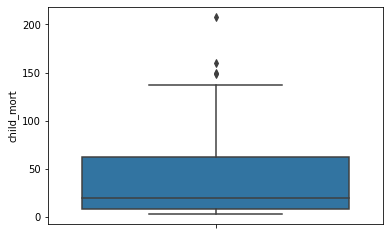

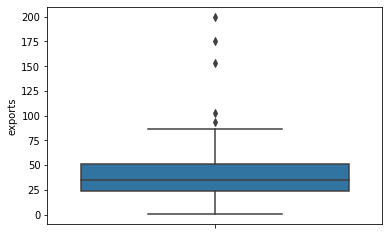

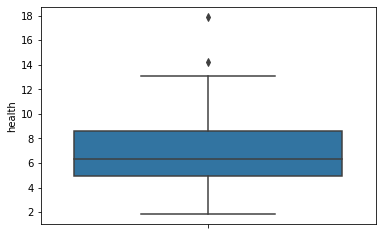

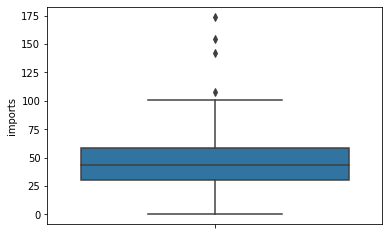

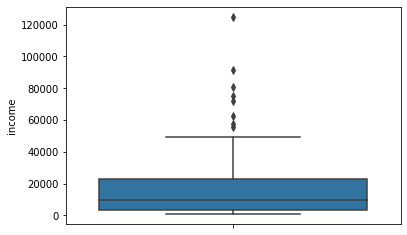

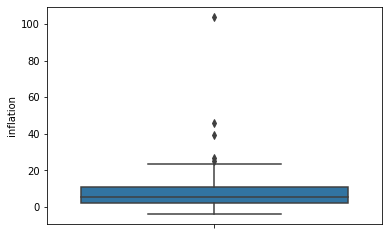

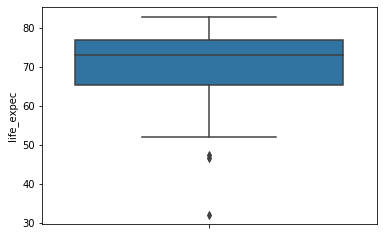

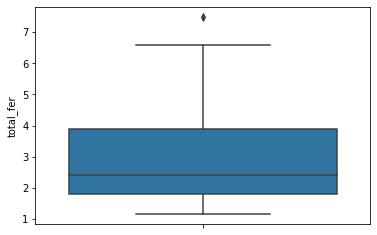

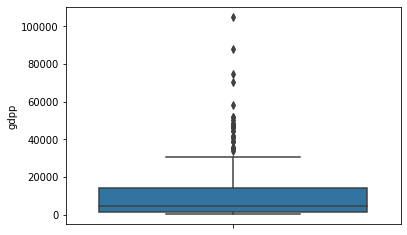

In [6]:
# Boxplot for each numeric column
for col in country_df.columns.drop('country'):
    sns.boxplot(y=col, data=country_df)
    plt.show()

### Observation:
- Statistically all the columns are having outliers
- Columns like child mortality, imports, inflation are having significant number of outliers on top. Also there are outliers on bottom on life expectency. These signifies that there are few countries which are far backward economically and socially
- Columns like exports, health, income, gdpp are having significant number of outliers on top signifying there are few countries which are far ahead economically and socially compared to others

### Actions on Outliers
- Since the objective of the NGO is to allocate money to countries who are dire need, we will not remove the outliers who are lagging behind economically and socially
- We will remove the outliers who are much ahead econimically and socially. Otherwise these countries will push away other countries from their cluster and we might get high number of countries in the cluster we are looking for

### Outlier removal

In [7]:
income_q3 = country_df.income.quantile(0.95)
gdpp_q3 = country_df.gdpp.quantile(0.95)

# Removing top 5% of countries who are high in income and gdpp
country_df = country_df[(country_df.child_mort <= income_q3) & (country_df.gdpp <= gdpp_q3)]

In [8]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,40.196203,39.447462,6.688671,46.378265,14614.955696,8.099367,69.966456,3.009620,9913.379747
std,40.622685,25.243334,2.683807,23.229783,15224.031790,10.759661,8.780099,1.533079,12717.283188
min,2.600000,0.109000,1.970000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,10.300000,23.575000,4.872500,30.475000,3290.000000,1.935000,64.150000,1.810000,1310.000000
50%,20.900000,34.000000,6.105000,43.250000,9790.000000,5.460000,71.850000,2.530000,4480.000000
75%,62.500000,50.675000,8.250000,58.475000,20100.000000,11.175000,76.400000,4.200000,12075.000000
max,208.000000,200.000000,17.900000,174.000000,80600.000000,104.000000,82.800000,7.490000,48400.000000


# Data Preparation

In [9]:
# Creating custom surrogate key as 'ID' for easy indentification of rows in future
country_df['ID'] = country_df.index+101

In [10]:
# New dataframe without Country column to be used in modelling
country_ndf = country_df.drop(['country'], axis=1)

In [11]:
# A snippet of current data
country_ndf.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,101
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,102
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,103
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,104
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,105


In [12]:
# Current shape of the dataframe
country_ndf.shape

(158, 10)

In [13]:
# Creating new dataframe with only the relevant features to be used directly in modelling
country_data = country_ndf.drop(["ID"], axis=1)

### Feature Scaling

In [14]:
# Scaling of numerical columns
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
country_data_scaled = standard_scaler.fit_transform(country_data)

### Finding Principal Components using PCA

In [15]:
# Initialization of PCA class with SVD solver as Randomized and Random State as 42
pca = PCA(svd_solver='randomized', random_state=42)

In [16]:
# Fitting the scaled data with PCA
pca.fit(country_data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [17]:
# Principal components with SVD solver methods for the scaled country data
pca.components_

array([[-4.29030525e-01,  2.55209832e-01,  1.34178285e-01,
         1.31450432e-01,  4.07693446e-01, -1.79172211e-01,
         4.31281152e-01, -4.14623599e-01,  3.99105167e-01],
       [ 1.11571336e-01,  6.26379514e-01, -2.77405040e-01,
         6.77160121e-01, -2.31878558e-02, -5.16544119e-02,
        -1.67479074e-01,  7.48372976e-02, -1.51147079e-01],
       [-4.15586874e-02,  1.65804096e-01, -6.21898369e-01,
        -3.00546950e-01,  2.52933247e-01,  6.41231036e-01,
         1.20926305e-01,  5.91157438e-03,  6.23316904e-02],
       [ 3.78896334e-01,  1.25334264e-01,  4.18106890e-01,
         3.92312068e-02,  4.08208237e-01,  2.46846528e-01,
        -2.31647606e-01,  3.66642523e-01,  4.98720267e-01],
       [-2.10302855e-01,  2.05622263e-02,  4.97644383e-01,
         2.62211666e-01, -2.60517467e-01,  6.88800973e-01,
         1.29156175e-01, -1.65619335e-01, -2.29167627e-01],
       [ 1.86245017e-01, -5.01345979e-02, -4.28272915e-03,
        -4.26434872e-02,  1.45028292e-01,  6.489172

In [18]:
# Checking spread(variance) of the principal components in explaing the original dataset
pca.explained_variance_ratio_

array([0.45480475, 0.1766364 , 0.13336189, 0.10604223, 0.07260472,
       0.02594781, 0.01392215, 0.01011373, 0.00656633])

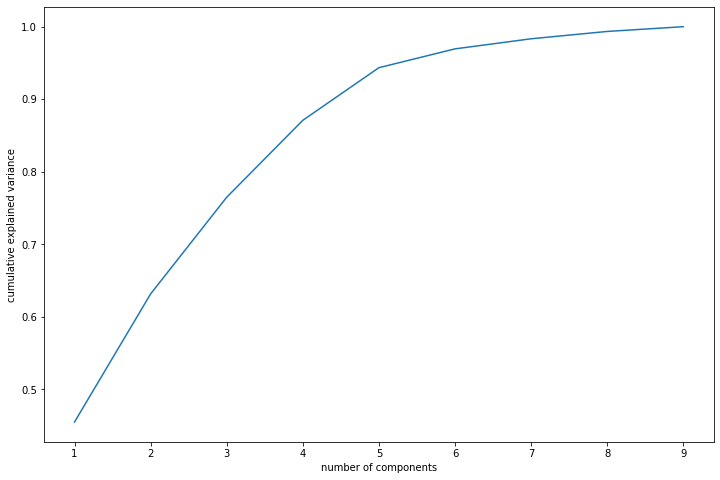

In [19]:
# Checking spread(variance) of the principal components using Scree plot
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### Observation:
- Scree plot suggests that the first 5 principal components alone can explain around 95% of the data
- We can continue with 5 principal components for doing rest of the analysis

In [20]:
# Applying incremental PCA method with 5 principal components
from sklearn.decomposition import IncrementalPCA
pca_inc = IncrementalPCA(n_components=5)

In [21]:
# Fitting and Transforming the scaled country dataset as per the basis
# represented by the first 5 principal components
df_pca = pca_inc.fit_transform(country_data_scaled)
df_pca.shape

(158, 5)

In [22]:
# Renaming the transformed dataframe's columns with the column names 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'
df_pca = pd.DataFrame(df_pca,\
                      columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [23]:
# A snippet of the Transformed dataset
df_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.899440,-0.210920,-0.794008,0.808073,-0.151098
1,0.571663,-0.365855,-0.285368,-1.233879,0.278467
2,-0.082299,-0.334262,1.307774,-0.813505,0.215401
3,-2.830780,1.451765,1.559083,1.124602,-0.375038
4,1.295018,0.323543,-0.154906,-0.664375,-0.173215


In [24]:
# Creating a new dataframe as df_final copying the dataset from the transformed dataframe
df_final = df_pca.copy()

In [25]:
# Applying surrogate key 'ID' as the Index of the df_final dataframe
df_final.index = country_ndf['ID']

In [26]:
# Reseting Index column to take 'ID' as a column of the new dataframe
df_final.reset_index(inplace=True)

# Looking shape of the new dataframe
df_final.shape

(158, 6)

In [27]:
# A data snippet of the new dataframe
df_final.head()

,ID,PC1,PC2,PC3,PC4,PC5
0,101,-2.899440,-0.210920,-0.794008,0.808073,-0.151098
1,102,0.571663,-0.365855,-0.285368,-1.233879,0.278467
2,103,-0.082299,-0.334262,1.307774,-0.813505,0.215401
3,104,-2.830780,1.451765,1.559083,1.124602,-0.375038
4,105,1.295018,0.323543,-0.154906,-0.664375,-0.173215


### Plotting the principal components pairwise

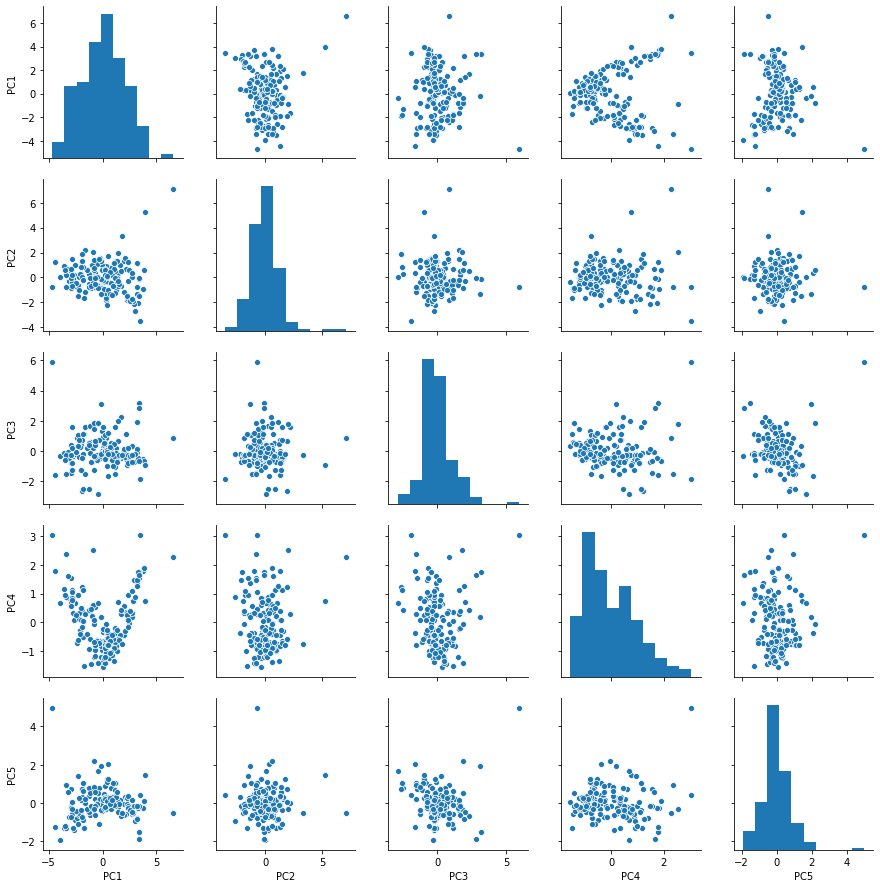

In [28]:
# Pair-wise scatter plot to confirm there is no linear depedency among the PC's
sns.pairplot(data=df_pca)

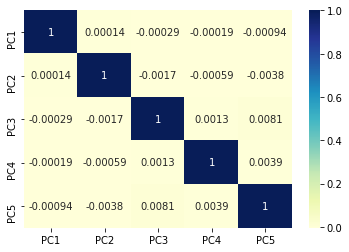

In [29]:
# Confirming there is no linear depedency among the PC's using correlation coefficients and heatmap
sns.heatmap(df_pca.corr(), annot=True, cmap="YlGnBu")

# Building Model

### Defining Hopkins function

In [30]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [31]:
# Checking Hopkins statistic for the PCA transformed data
hopkins(df_pca)

0.8288100297152905

### Observation:
- We are getting good value of Hopkins Statistic signifying the dataset is can be clustered

### Analysis via Silhoutte score

For n_clusters = 2, silhouette score is 0.30131428372202196
For n_clusters = 3, silhouette score is 0.31518436070815914
For n_clusters = 4, silhouette score is 0.32329052420165705
For n_clusters = 5, silhouette score is 0.32700265790666905
For n_clusters = 6, silhouette score is 0.25640006993383224
For n_clusters = 7, silhouette score is 0.2757180052956421
For n_clusters = 8, silhouette score is 0.25226964269298635
For n_clusters = 9, silhouette score is 0.2535071232435092


Text(0.5, 1.0, 'Silhouette Score')

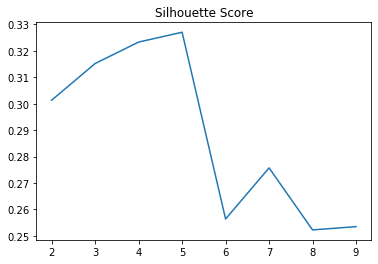

In [32]:
from sklearn.metrics import silhouette_score
sse_ = []

# Iteration for Silhoutte score
for n_clusters in range(2,10):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_pca)
    centers = clusterer.cluster_centers_
    score = silhouette_score(df_pca, preds, metric='euclidean')
    sse_.append([n_clusters, score])
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

# Plotting the Silhoutte score
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette Score")

### Silhoutte score suggests that 5 can be an Ideal number of cluster for K-Means clustering method. <br> Lets check Elbow curve if we can have a less number of cluster comparing the data volume

### Analysis via Elbow curve

Text(0.5, 1.0, 'Elbow Curve')

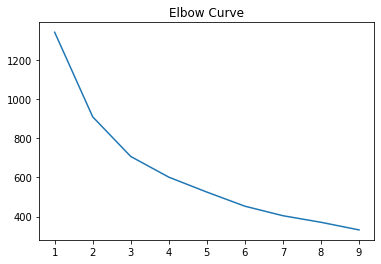

In [33]:
ssd = []

# Iteration for generating SSD(Sum Squared Distances) for Elobw curve
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_pca)
    ssd.append([num_clusters, model_clus.inertia_])
  
# Plotting SSD's for Elbow curve
plt.plot(pd.DataFrame(ssd)[0],pd.DataFrame(ssd)[1])
plt.title("Elbow Curve")

### Elbow curve suggests that 3 can be an Ideal number of cluster for K-Means clustering method

In [34]:
# Perform K-Means using K=3 with maximum iteration of 50 and random state as 50
model_clus2 = KMeans(n_clusters = 3, max_iter=50, random_state = 50)

# Fitting on the PCA transformed dataframe
model_clus2.fit(df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [35]:
# Assigning the cluster-id's to the dataframe
df_final['KMeans-CID'] = model_clus2.labels_

In [36]:
# Checking number of rows allocated to each cluster'id's
df_final['KMeans-CID'].value_counts()

1    83
2    45
0    30
Name: KMeans-CID, dtype: int64

In [37]:
# Data snippet the final dataset after clustering
df_final.head()

,ID,PC1,PC2,PC3,PC4,PC5,KMeans-CID
0,101,-2.899440,-0.210920,-0.794008,0.808073,-0.151098,2
1,102,0.571663,-0.365855,-0.285368,-1.233879,0.278467,1
2,103,-0.082299,-0.334262,1.307774,-0.813505,0.215401,1
3,104,-2.830780,1.451765,1.559083,1.124602,-0.375038,2
4,105,1.295018,0.323543,-0.154906,-0.664375,-0.173215,1


In [38]:
# Merging Original country dataframe with the clustered dataframe to get the cluster of each country
country_data_k = pd.merge(country_df, df_final, how='inner', on='ID')

In [39]:
# Snippet of merged data
country_data_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ID,PC1,PC2,PC3,PC4,PC5,KMeans-CID
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,101,-2.899440,-0.210920,-0.794008,0.808073,-0.151098,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,102,0.571663,-0.365855,-0.285368,-1.233879,0.278467,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,103,-0.082299,-0.334262,1.307774,-0.813505,0.215401,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,104,-2.830780,1.451765,1.559083,1.124602,-0.375038,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,105,1.295018,0.323543,-0.154906,-0.664375,-0.173215,1


### Analysis of GDP, Child Mortality and Income for each cluster

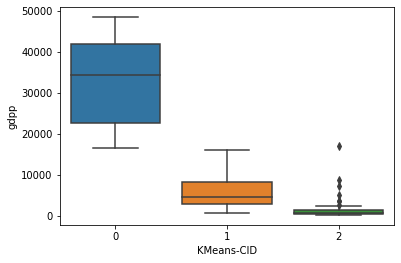

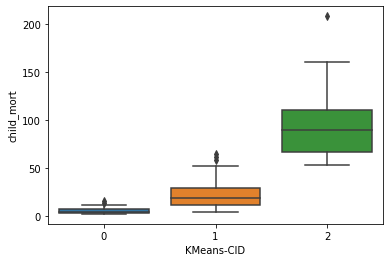

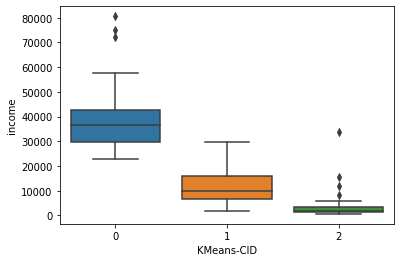

In [40]:
# Box plot of GDP for each cluster
sns.boxplot(x='KMeans-CID', y='gdpp', data=country_data_k)
plt.show()

# Boxplot of Child mortality for each cluster
sns.boxplot(x='KMeans-CID', y='child_mort', data=country_data_k)
plt.show()

# Box plot of income for each cluster
sns.boxplot(x='KMeans-CID', y='income', data=country_data_k)
plt.show()

### Observation
- Cluster 2 countries are of low GDP, high child mortality and low income group
- Cluster 0 countries are of high GDP, low child mortality and high income group
- Cluster 1 countries are of medium GDP, child mortality and income

### K-Means Clustering Conclusion:
- Cluster 2 countries are in dire need of financial need. The NGO should give the aid to them.

## List of countries needing aid - as per K-Means clustering

In [52]:
country_data_k[country_data_k['KMeans-CID']==2]['country']

0                   Afghanistan
3                        Angola
16                        Benin
24                 Burkina Faso
25                      Burundi
27                     Cameroon
30     Central African Republic
31                         Chad
35                      Comoros
36             Congo, Dem. Rep.
37                  Congo, Rep.
39                Cote d'Ivoire
47            Equatorial Guinea
48                      Eritrea
53                        Gabon
54                       Gambia
57                        Ghana
61                       Guinea
62                Guinea-Bissau
64                        Haiti
77                        Kenya
78                     Kiribati
81                          Lao
84                      Lesotho
85                      Liberia
89                   Madagascar
90                       Malawi
93                         Mali
95                   Mauritania
102                  Mozambique
104                     Namibia
107     

# Hierarchical Clustering

### Single Linkage

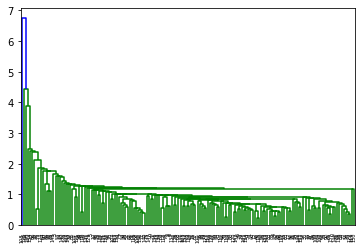

In [42]:
# Running the Hierarchical Clustering method using Single Linkage
mergings = linkage(df_pca, method="single", metric='euclidean')

# Generating and plotting the Dendrogram
dendrogram(mergings)
plt.show()

### Observation
- The plot is not clear enough to cut the tree and decide the number of cluster
- Single Linkage is not good enough. We should be doing using complete linkage

### Complete Linkage

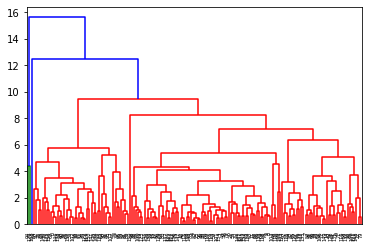

In [43]:
# Running the Hierarchical Clustering method using Complete Linkage 
mergings = linkage(df_pca, method="complete", metric='euclidean')

# Generating and plotting the Dendrogram
dendrogram(mergings)
plt.show()

### Observation:
- Complete Linkage shows a possibility of cutting the tree at 9 resulting in 3 cluster
- With 3 cluster, distribute the data in a skewed form with most of the countries going in one cluster
- Complete Linake also shows a possibility of cutting the tree between 7 and 8, resulting in 4 cluster
- With 4 cluster, skewness of distribution seems to be overcomed

### We will proceed with 4 cluster cutting the tree between 7 and 8

In [44]:
# Generating cluster id's with cluster number = 4
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0])

In [45]:
# Assigning the cluster id's to the dataframe to identify the countries for each cluster
df_final['H-CID'] = cluster_labels

In [46]:
# Merging clustered dataframe with the original dataframe
country_data_h = pd.merge(country_df, df_final, how='inner', on='ID')

In [47]:
# Checking number of countries in each cluster
country_data_h['H-CID'].value_counts()

1    110
0     45
2      2
3      1
Name: H-CID, dtype: int64

### Analysis of GDP, child mortality and income for each cluster

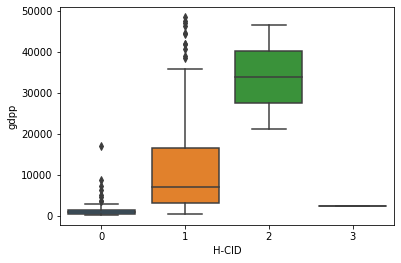

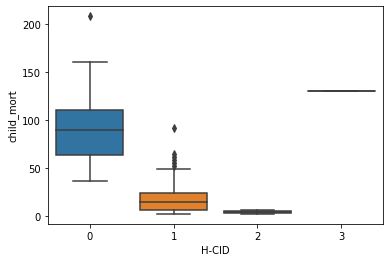

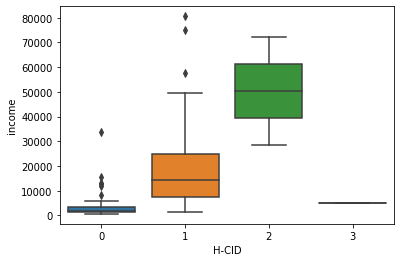

In [48]:
# Box plot of GDP for each cluster
sns.boxplot(x='H-CID', y='gdpp', data=country_data_h)
plt.show()

# Box plot of child mortality for each cluster
sns.boxplot(x='H-CID', y='child_mort', data=country_data_h)
plt.show()

# Box plot of income for each cluster
sns.boxplot(x='H-CID', y='income', data=country_data_h)
plt.show()

### Observation
- Cluster 0 and 3 countries are of low GDP, high child mortality and low income group
- Cluster 2 countries are of high GDP, low child mortality and high income group
- Cluster 1 countries are of medium GDP, child mortality and income

### Hierarchical Clustering Conclusion:
- Cluster 0 and 3 countries are in dire need of financial need. The NGO should give the aid to them.

## List of countries needing aid - as per Hierarchical clustering

In [49]:
country_data_h[(country_data_h["H-CID"].isin([0,3]))]['country']

0                   Afghanistan
3                        Angola
16                        Benin
20                     Botswana
24                 Burkina Faso
25                      Burundi
27                     Cameroon
30     Central African Republic
31                         Chad
35                      Comoros
36             Congo, Dem. Rep.
37                  Congo, Rep.
39                Cote d'Ivoire
47            Equatorial Guinea
53                        Gabon
54                       Gambia
57                        Ghana
61                       Guinea
62                Guinea-Bissau
64                        Haiti
70                         Iraq
77                        Kenya
78                     Kiribati
81                          Lao
84                      Lesotho
85                      Liberia
89                   Madagascar
90                       Malawi
93                         Mali
95                   Mauritania
97        Micronesia, Fed. Sts.
102     

# Cluster Profile

### Cluster profile for K-Means clustered data

In [50]:
k_child_M = pd.DataFrame(country_data_k.groupby(['KMeans-CID']).child_mort.mean())
k_income = pd.DataFrame(country_data_k.groupby(['KMeans-CID']).income.mean())
k_gdpp = pd.DataFrame(country_data_k.groupby(['KMeans-CID']).gdpp.mean())
k_ClusterProfie = pd.concat([k_child_M, k_income, k_gdpp], axis=1)
k_ClusterProfie

,child_mort,income,gdpp
KMeans-CID,,,
0,6.036667,40126.666667,33256.666667
1,22.772289,11398.433735,5892.915663
2,95.106667,3539.844444,1766.711111


### Cluster profile for Hierarchical clustred data

In [51]:
# Let's create cluster profile
h_child_M = pd.DataFrame(country_data_h.groupby(['H-CID']).child_mort.mean())
h_income = pd.DataFrame(country_data_h.groupby(['H-CID']).income.mean())
h_gdpp = pd.DataFrame(country_data_h.groupby(['H-CID']).gdpp.mean())
h_ClusterProfie = pd.concat([h_child_M, h_income, h_gdpp], axis=1)
h_ClusterProfie

,child_mort,income,gdpp
H-CID,,,
0,91.820000,3950.733333,1985.777778
1,18.904545,18416.636364,12790.218182
2,4.800000,50200.000000,33850.000000
3,130.000000,5150.000000,2330.000000
